In [1]:
#!python -m pip install sbi

In [2]:
import torch

import matplotlib.pyplot as plt
import os
import numpy as np

from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.analysis.plot import sbc_rank_plot, plot_tarp
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [3]:
#https://drive.google.com/file/d/1xOaP1N7OBL1SoULSRtxoEbvVpXvXERKD/view?usp=sharing
#file contains the array k - values of 20 wave vector bins
#Pks - simulated noisy dark matter power spectra (5_000,25)
#params - correspondent cosmological parameters \omega_cdm and ln10^10A_s (5_000,2)

In [4]:
data_path = 'sbi_data.npz'
Pks = np.load(data_path)['pk']
params =  np.load(data_path)['params']
k = np.load(data_path)['k']
params.shape, Pks.shape, k.shape

((5000, 2), (5000, 25), (25,))

#### 1. Inspect the data. Make log-log plots of the few power spectra

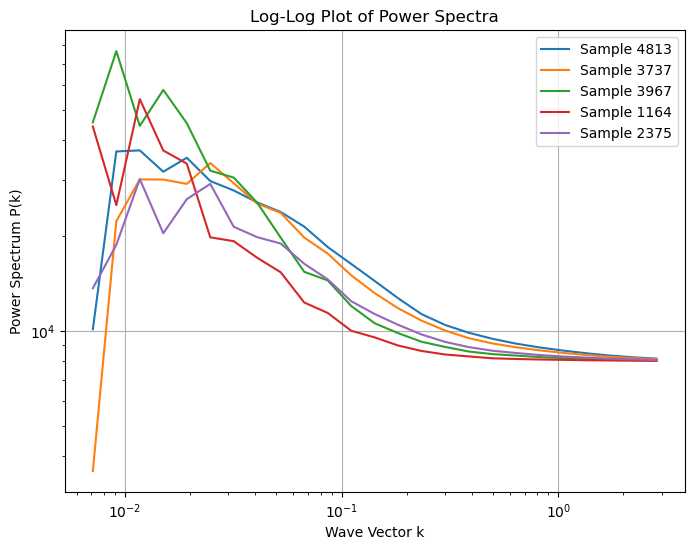

In [5]:
indices = np.random.choice(Pks.shape[0], 5, replace=False)

plt.figure(figsize=(8, 6))
for idx in indices:
    plt.loglog(k, Pks[idx], label=f"Sample {idx}")
plt.xlabel("Wave Vector k")
plt.ylabel("Power Spectrum P(k)")
plt.title("Log-Log Plot of Power Spectra")
plt.legend()
plt.grid(True)
plt.show()

#### 2. Initialize a uniform 2D prior that covers the whole parameter range
Follow the tutorial on sbi: https://sbi-dev.github.io/sbi/latest/tutorials/00_getting_started/

In [6]:
param_mins, param_maxs = params.min(axis=0), params.max(axis=0)

prior = BoxUniform(low=torch.tensor(param_mins, dtype=torch.float32),
                   high=torch.tensor(param_maxs, dtype=torch.float32))

print(f'Param Minimums:{param_mins}\nParam Maximums:{param_maxs}')

Param Minimums:[0.05000665 1.61015536]
Param Maximums:[0.2549878  3.90935009]


In [7]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
print(f'Prior: {prior}\nNumber of Parameters: {num_parameters}\nPrior Numpy: {prior_returns_numpy}')

Prior: BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)
Number of Parameters: 2
Prior Numpy: False


#### 3. Train the NPE
Use 4000 samples for training

In [8]:
inference = NPE(prior=prior)

num_simulations = 4000

theta = prior.sample((num_simulations,))
x = torch.tensor(Pks[:num_simulations], dtype=torch.float32)

print(f'theta.shape: {theta.shape}\nx.shape: {x.shape}')

theta.shape: torch.Size([4000, 2])
x.shape: torch.Size([4000, 25])


In [9]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 96 epochs.

#### 4. Visually inspect the posteriors on unseen data

In [10]:
posterior = inference.build_posterior(density_estimator)
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [11]:
x_unseen = torch.tensor(Pks[num_simulations:], dtype=torch.float32)
print(f'x.shape: {x_unseen.shape}')

x.shape: torch.Size([1000, 25])


In [12]:
i = 123

samples = posterior.sample((50000,), x=x_unseen[i])

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

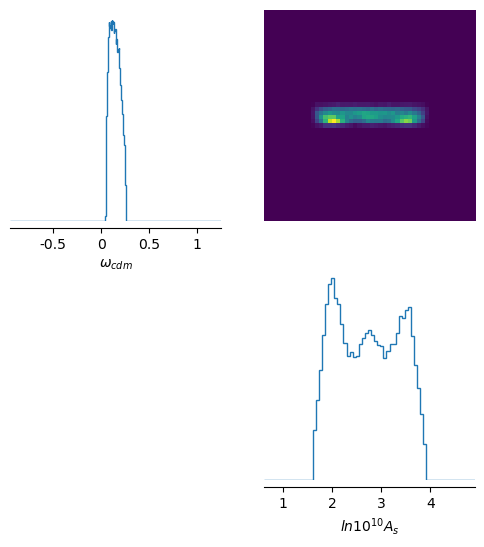

In [13]:
pairplot(samples,
        limits=[[param_mins[0]-1, param_maxs[0]+1], [param_mins[1]-1, param_maxs[1]+1]], figsize=(6, 6),
        labels=[r"$\omega_{cdm}$", r"$ln{10^{10}A_s}$"]);

#### 5. Perform simulation based calibration diagnostic checks on the unseen data
https://sbi-dev.github.io/sbi/latest/tutorials/11_diagnostics_simulation_based_calibration/

Choose about 400-500 samples to do the sbc

In [14]:
num_sbc_samples = 400

thetas = prior.sample((num_sbc_samples,))
xs = torch.tensor(Pks[num_simulations:(num_simulations+num_sbc_samples)], dtype=torch.float32)

print(f'theta.shape: {thetas.shape}\nx.shape: {xs.shape}')

theta.shape: torch.Size([400, 2])
x.shape: torch.Size([400, 25])


In [15]:
num_posterior_samples = 1_000
num_workers = 1
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples, num_workers=num_workers
)

print(f'ranks.shape: {ranks.shape}\ndap_samples.shape: {dap_samples.shape}')

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 400 sbc samples.:   0%|          | 0/400 [00:00<?, ?it/s]

ranks.shape: torch.Size([400, 2])
dap_samples.shape: torch.Size([400, 2])


In [16]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
check_stats

{'ks_pvals': tensor([1.2022e-05, 1.5663e-01]),
 'c2st_ranks': tensor([0.5275, 0.5450], dtype=torch.float64),
 'c2st_dap': tensor([0.4987, 0.5200], dtype=torch.float64)}

##### 5.1 Check the ranks of the posterior vs. uniform
https://sbi-dev.github.io/sbi/latest/tutorials/11_diagnostics_simulation_based_calibration/#ranks-versus-uniform-distribution

In [17]:
print(
    f"""kolmogorov-smirnov p-values: \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}
    \n\nc2st accuracies: \n
    check_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}
    """
)

kolmogorov-smirnov p-values: 

    check_stats['ks_pvals'] = [1.2021947e-05 1.5663439e-01]
    

c2st accuracies: 

    check_stats['c2st_ranks'] = [0.5275 0.545 ]
    


##### 5.2 Check the DAP
https://sbi-dev.github.io/sbi/latest/tutorials/11_diagnostics_simulation_based_calibration/#data-averaged-posterior-dap-versus-prior

In [18]:
print(
    f"""c2st accuracies \n
    check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}""")

c2st accuracies 

    check_stats['c2st_dap'] = [0.49875 0.52   ]


##### 5.3 Visualize the distribution of ranks and compute the empirical cdf
https://sbi-dev.github.io/sbi/latest/tutorials/11_diagnostics_simulation_based_calibration/#visual-inspection

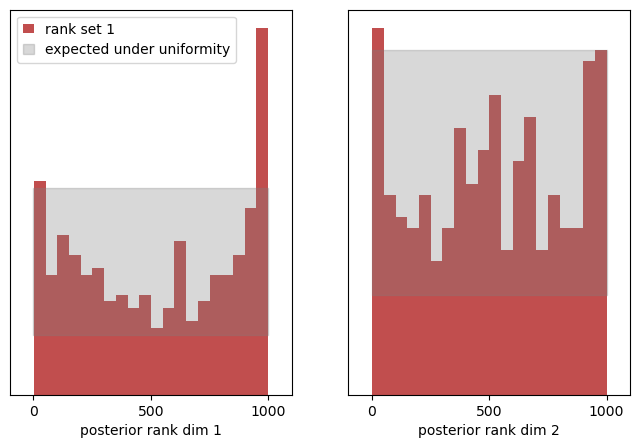

In [19]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,
)

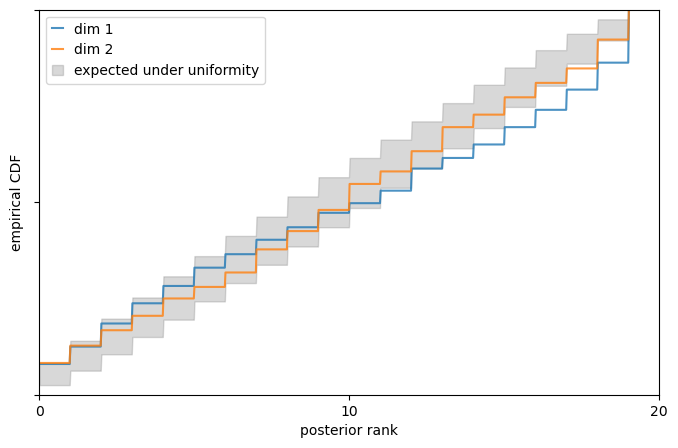

In [20]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

##### 5.4 Do the TARP callibration check
https://sbi-dev.github.io/sbi/latest/tutorials/11_diagnostics_simulation_based_calibration/#posterior-calibration-with-tarp-lemos-et-al-2023

In [21]:
ecp, alpha = run_tarp(
    thetas,
    xs,
    posterior,
    references=None,
    num_posterior_samples=1000,
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
atc, ks_pval = check_tarp(ecp, alpha)
print(atc, "Should be close to 0")
print(ks_pval, "Should be larger than 0.05")

-0.04499948024749756 Should be close to 0
0.9999999953860058 Should be larger than 0.05


(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Credibility Level $\\alpha$', ylabel='Expected Coverage Probability'>)

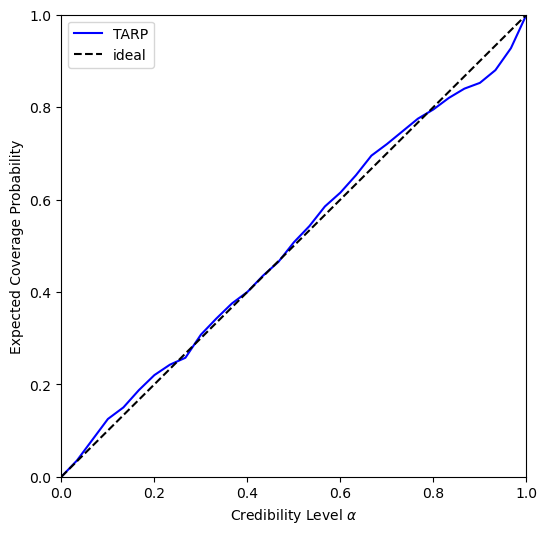

In [23]:
plot_tarp(ecp, alpha)